In [1]:
import pypsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
network = pypsa.Network()
network.set_snapshots(range(8760))

In [3]:
network.add("Bus", "Baltra", x=-90.27286, y=-0.45831)
network.add("Bus", "Puerto_Ayora", x=-90.31481, y=-0.74218)
network.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,
Baltra,1.0,,-90.27286,-0.45831,AC,None,1.0,0.0,inf,PQ,
Puerto_Ayora,1.0,,-90.31481,-0.74218,AC,None,1.0,0.0,inf,PQ,


In [4]:
network.add('Link', 'link', bus0='Baltra', bus1='Puerto_Ayora', p_nom=10, p_min_pu = -1)

In [5]:
wind_NE = pd.read_csv('../Data/Wind_2011.csv')['NE'].to_numpy()
solar_NE = pd.read_csv('../Data/PV_2011.csv')['NE'].to_numpy()
solar_SE = pd.read_csv('../Data/PV_2011.csv')['SE'].to_numpy()

In [6]:
network.add("Generator", "Diesel", bus="Puerto_Ayora", p_nom=8, marginal_cost=50)
network.add("Generator", "PV_Baltra", bus="Baltra", p_nom=0.2, p_max_pu=solar_NE)
network.add("Generator", "PV_Puerto_Ayora", bus="Baltra", p_nom=1.5, p_max_pu=solar_SE)
network.add("Generator", "Wind_Baltra", bus="Baltra", p_nom=2.25, p_max_pu=wind_NE)

In [7]:
# storage unit to do price arbitrage
network.add("StorageUnit", 'Lead-acid', bus='Baltra', p_nom=500, max_hours=8, marginal_cost=0.0001)  # energy storage in terms of hours at full power
network.add("StorageUnit", 'Li-ion', bus='Baltra', p_nom=0.4, max_hours=1, marginal_cost=0.0001)  # energy storage in terms of hours at full power

In [8]:
network.add("Load", "Load_Baltra", bus="Baltra", p_set=2)
network.add("Load", "Load_Puerto_Ayora", bus="Puerto_Ayora", p_set=5)

In [9]:
network.lopf(pyomo=False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.83s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 2.81e+06


('ok', 'optimal')

Text(0.5, 0, '')

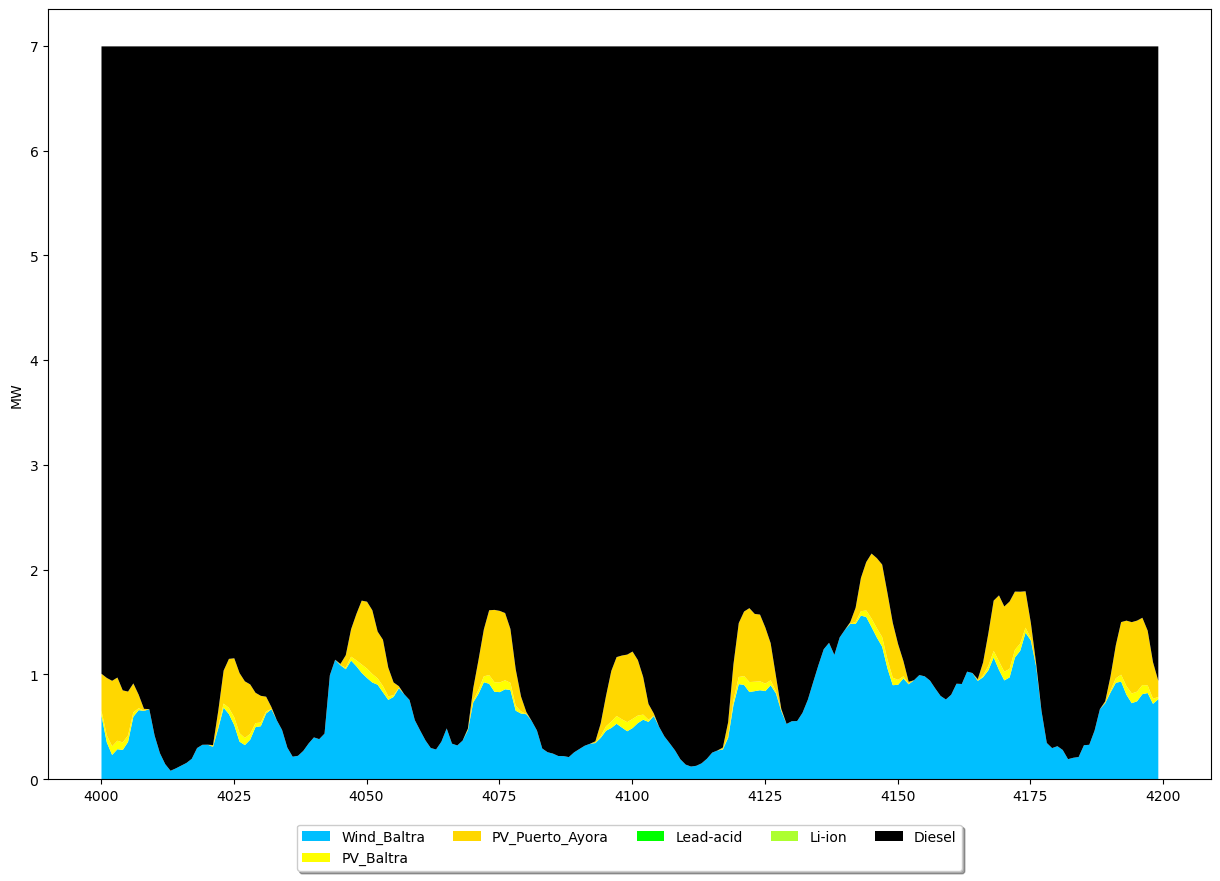

In [10]:
p_by_carrier = network.generators_t.p

storage_by_carrier = network.storage_units_t.p

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

cols = ['Wind_Baltra', 'PV_Baltra', 'PV_Puerto_Ayora', 'Lead-acid', 'Li-ion', "Diesel"]
p_by_carrier = p_by_carrier[cols]

colors = {"Diesel": "black",
          "Wind_Baltra": "deepskyblue",
          "PV_Baltra": "yellow",
          'PV_Puerto_Ayora': 'gold',
          'Lead-acid': 'lime',
          'Li-ion': 'greenyellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier[4000:4200]).plot(
    kind='area', ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("MW")

ax.set_xlabel("")

Text(0.5, 0, '')

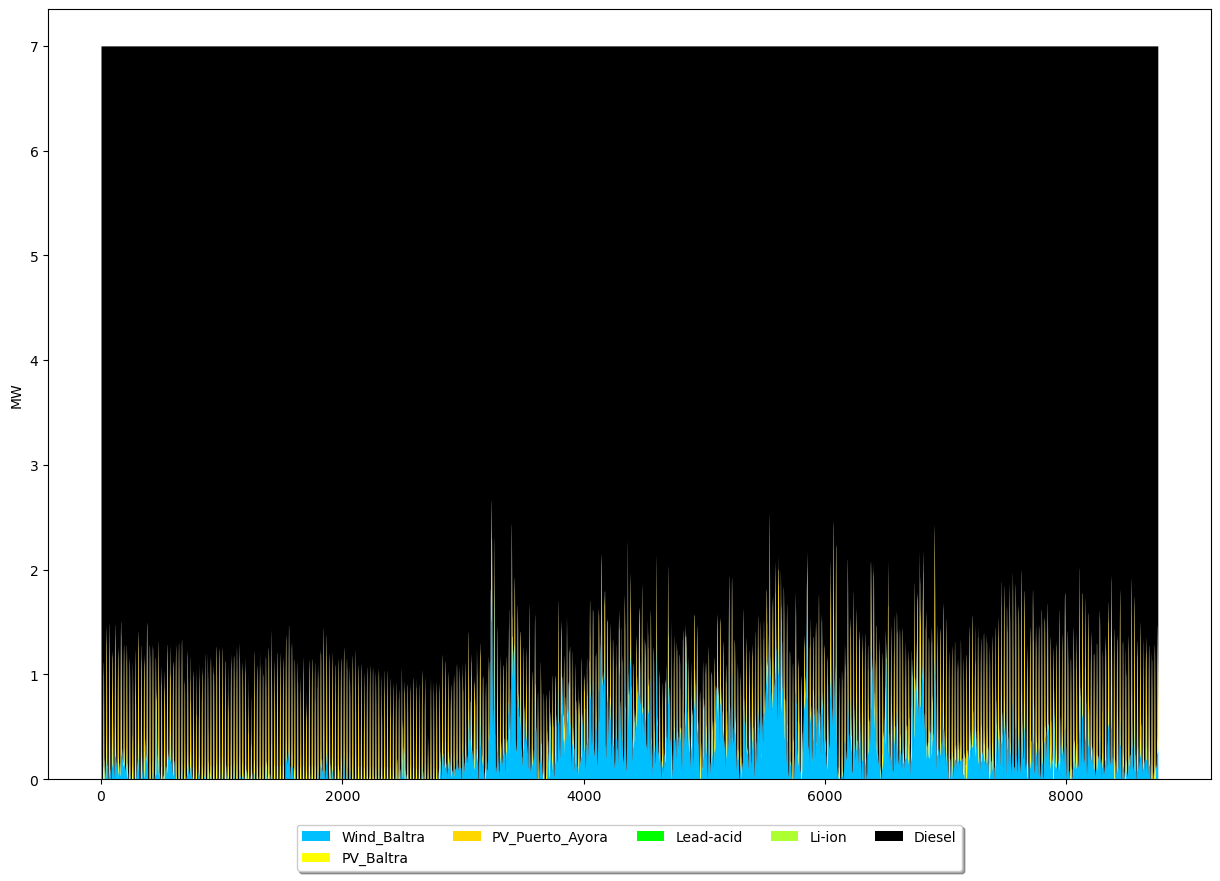

In [11]:
p_by_carrier = network.generators_t.p

storage_by_carrier = network.storage_units_t.p

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

cols = ['Wind_Baltra', 'PV_Baltra', 'PV_Puerto_Ayora', 'Lead-acid', 'Li-ion', "Diesel"]
p_by_carrier = p_by_carrier[cols]

colors = {"Diesel": "black",
          "Wind_Baltra": "deepskyblue",
          "PV_Baltra": "yellow",
          'PV_Puerto_Ayora': 'gold',
          'Lead-acid': 'lime',
          'Li-ion': 'greenyellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier).plot(
    kind='area', ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("MW")

ax.set_xlabel("")

c:\Users\alyden\Anaconda3\envs\pypsa\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


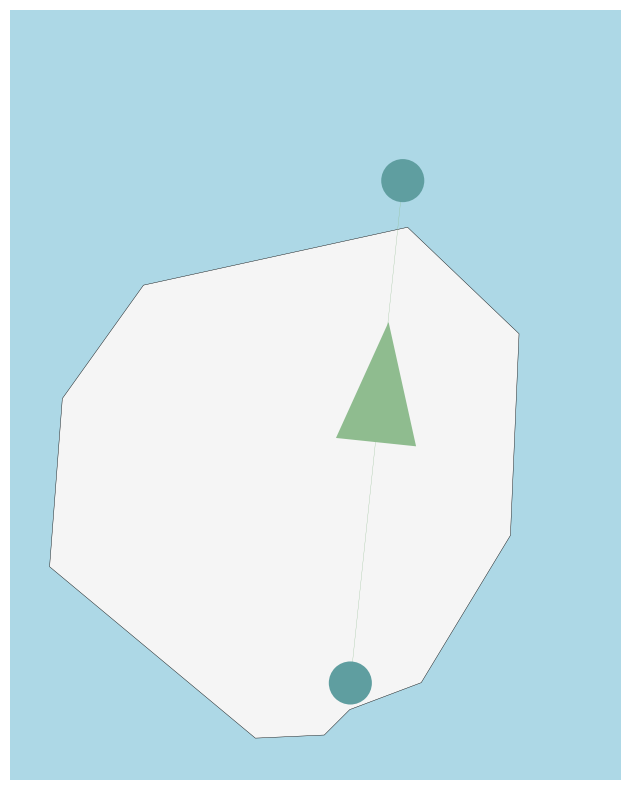

In [12]:
# links are not displayed for prettier output ('link_widths=0')
plt.rc("figure", figsize=(15,10))
flow = pd.Series(10, index=network.branches().index)
network.plot(
    bus_sizes=1 / 5e3,
    # bus_colors={"gas": "indianred", "wind": "midnightblue"},
    boundaries=[-90.57, -90.11, -0.3619, -0.797],
    flow='mean',
    link_widths=0.2,
    projection=ccrs.EqualEarth(),
    color_geomap=True,
)
plt.show()

In [13]:
# add some more renewables
# network.generators.p_nom_extendable = True
# network.generators['capital_cost'] = 10
# print(network.generators)
# network.links.p_nom_extendable = True
# # network.links.capital_cost = 10
network.storage_units
# # print(network.storage_units)
# # network.storage_units.capital_cost = 10
network.generators.p_nom.Wind_Baltra = 10
network.generators.p_nom.PV_Puerto_Ayora = 20
network.storage_units

C:\Users\alyden\AppData\Local\Temp\ipykernel_5640\3034355142.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  network.generators.p_nom.Wind_Baltra = 20
C:\Users\alyden\AppData\Local\Temp\ipykernel_5640\3034355142.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  network.generators.p_nom.PV_Puerto_Ayora = 20


In [14]:
network.lopf(pyomo=False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.84s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 4.47e+05


('ok', 'optimal')

Text(0.5, 0, '')

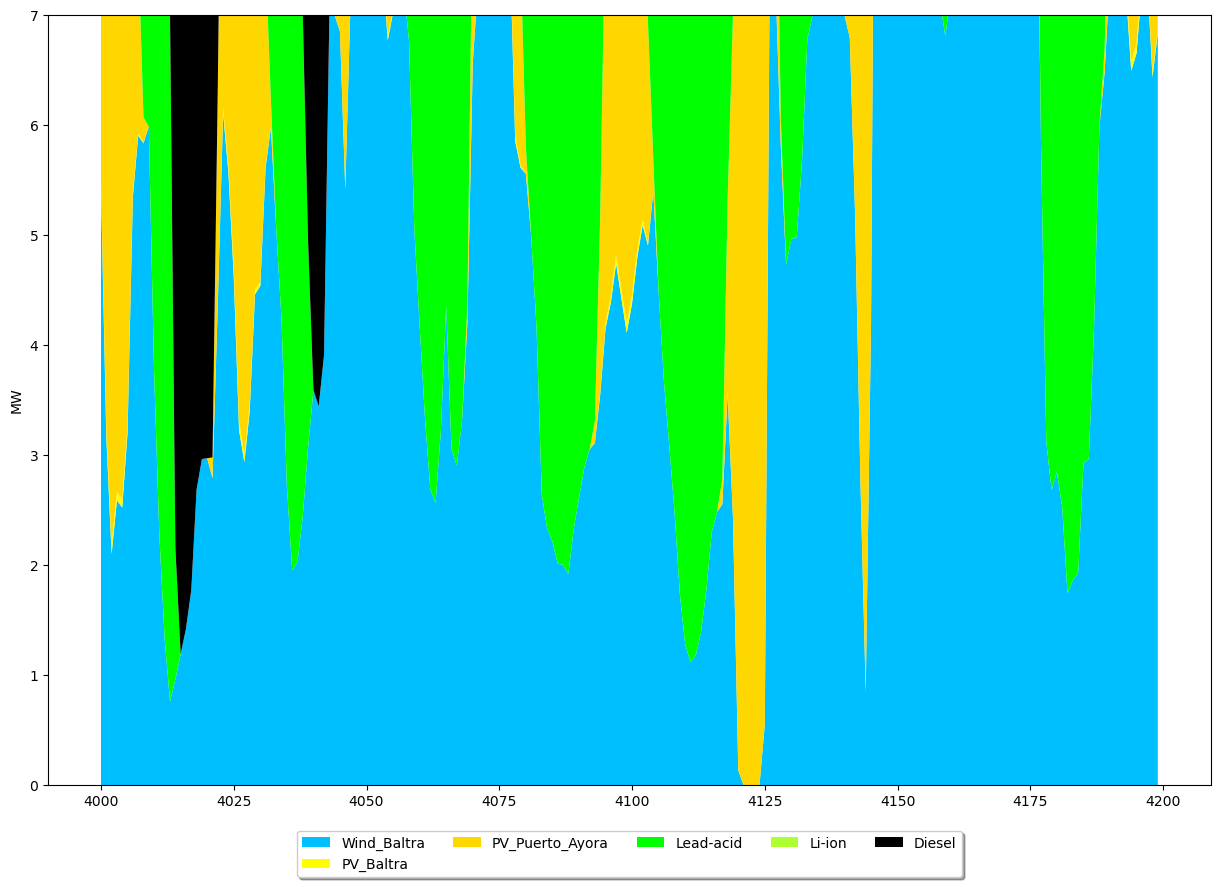

In [16]:
p_by_carrier = network.generators_t.p

storage_by_carrier = network.storage_units_t.p

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

cols = ['Wind_Baltra', 'PV_Baltra', 'PV_Puerto_Ayora', 'Lead-acid', 'Li-ion', "Diesel"]
p_by_carrier = p_by_carrier[cols]

colors = {"Diesel": "black",
          "Wind_Baltra": "deepskyblue",
          "PV_Baltra": "yellow",
          'PV_Puerto_Ayora': 'gold',
          'Lead-acid': 'lime',
          'Li-ion': 'greenyellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier[4000:4200]).plot(
    kind='area', ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])
ax.set_ylim(0, 7)
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("MW")

ax.set_xlabel("")